In this notebook, we will take a look at Recurrent Neural Networks and how to implement them im TensorFlow. We will also dive in more depth into the TensorFlow Data API. The notebook builds on a combination of the GitHub repository by [Aurélien Géron](https://github.com/ageron/handson-ml2) and official TensorFlow tutorials.

In [1]:
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, BatchNormalization, LSTM, Conv1D, Embedding, GRU
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.data import Dataset, TFRecordDataset

# 1. Introduction to RNNs

## 1.1 Generating sequence data

We start by creating a function that produces artifical time-series - which we will then try to predict.

In [2]:
def generate_time_series(dataset_size, seq_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, dataset_size, 1)
    time = np.linspace(0, 1, seq_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(dataset_size, seq_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

Let's create a few time-series. We choose sequence lengths of 50 and we will try to predict the 51st data point. Note that this fixed sequence length is only necessary for using feed-forward networks. With RNNs, we can work with arbitrary sequence lengths.

In [3]:
np.random.seed(132)
seq_steps = 50
series = generate_time_series(3000, seq_steps + 1)

X_train, y_train = series[:2000, :seq_steps], series[:2000, -1]
X_valid, y_valid = series[2000:2500, :seq_steps], series[2000:2500, -1]
X_test, y_test = series[2500:, :seq_steps], series[2500:, -1]

print(X_train.shape)
print(y_train.shape)

(2000, 50, 1)
(2000, 1)


The next function provides us with the means to plot both the sequence that we use for training, the actual next point that we want to predict, as well as our predictions (if given). Don't worry too much about the details, there is also some stuff that will only be relevant in the latter parts.

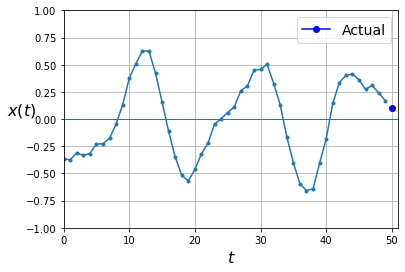

In [4]:
def plot_series(X, Y, Y_pred = None, series_to_plot = 0):
    seq_steps = X.shape[1]
    ahead = Y.shape[1]
    plt.plot(X[series_to_plot, :, 0], ".-")
    plt.grid(True)
    plt.xlabel("$t$", fontsize=16)
    plt.ylabel("$x(t)$", fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, seq_steps + ahead, -1, 1])   
    plt.plot(np.arange(seq_steps, seq_steps + ahead), Y[series_to_plot, :], "bo-", label="Actual")
    if not Y_pred is None:
        plt.plot(np.arange(seq_steps, seq_steps + ahead), Y_pred[series_to_plot, :], "rx-", label="Forecast", markersize=10)
    plt.legend(fontsize=14)
    plt.show()


plot_series(X_valid, y_valid, series_to_plot = 0)

## 1.2 Baselines

It tends to be quite easy to predict one step ahead. For example, if you want a very good prediction for the weather tomorrow, just take the weather today. Of course, it varies a bit by location, but in many places that already gives you a great prediction. Hence, we will establish two simple baselines to compare our RNN model to.

### 1.2.1 Predicting the most recent value

First is the "next is same as last" prediction:

In [5]:
y_pred = X_valid[:, -1]
np.mean(mean_squared_error(y_valid, y_pred))

0.019805497

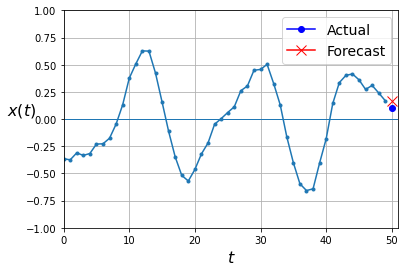

In [6]:
plot_series(X_valid, y_valid, y_pred, series_to_plot = 0)

### 1.2.2 Using a linear regression

Next, we train a linear regression on our data. Because we have 50 time steps for which we know the data, we also need 50 inputs:

In [7]:
model = Sequential([
    Flatten(input_shape=[50, 1]),
    Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


We will train (and plot) our models with a pre-defined function, so that we have to do less repetitions when creating all sorts of different models.

In [8]:
def train_plot(model, learning_rate = 0.001, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    model.compile(loss="mse",
                  optimizer=Adam(learning_rate = learning_rate))
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = model.fit(X_train, y_train, epochs=epochs,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    y_pred = model.predict(X_valid)
    plot_series(X_valid, y_valid, y_pred, 0)
    
    return model

Epoch 1/20
63/63 [==============================] - 0s 2ms/step - loss: 0.2252 - val_loss: 0.1174
Epoch 2/20
63/63 [==============================] - 0s 887us/step - loss: 0.0886 - val_loss: 0.0672
Epoch 3/20
63/63 [==============================] - 0s 912us/step - loss: 0.0630 - val_loss: 0.0528
Epoch 4/20
63/63 [==============================] - 0s 887us/step - loss: 0.0509 - val_loss: 0.0430
Epoch 5/20
63/63 [==============================] - 0s 903us/step - loss: 0.0418 - val_loss: 0.0355
Epoch 6/20
63/63 [==============================] - 0s 855us/step - loss: 0.0349 - val_loss: 0.0294
Epoch 7/20
63/63 [==============================] - 0s 887us/step - loss: 0.0294 - val_loss: 0.0255
Epoch 8/20
63/63 [==============================] - 0s 855us/step - loss: 0.0253 - val_loss: 0.0218
Epoch 9/20
63/63 [==============================] - 0s 871us/step - loss: 0.0221 - val_loss: 0.0193
Epoch 10/20
63/63 [==============================] - 0s 887us/step - loss: 0.0195 - val_loss: 0.0174
E

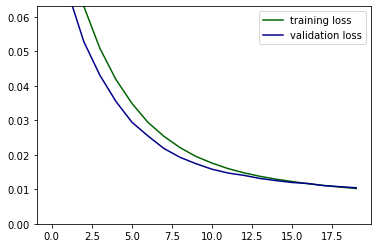

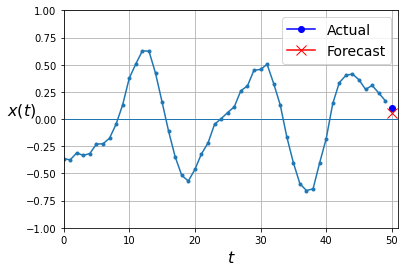

In [9]:
train_plot(model)

## 1.3 A simple RNN

We now try out a **very** simple RNN: one layer with one recurrent neuron. Note here, that we don't have to specify the length of the sequence. Our RNN will "unfold" to accomodate any sequence length as necessary!

In [10]:
model = Sequential([
    SimpleRNN(1, input_shape=[None, 1])
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
63/63 [==============================] - 1s 6ms/step - loss: 0.4663 - val_loss: 0.4781
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 0.4486 - val_loss: 0.4610
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 0.4340 - val_loss: 0.4459
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4316
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 0.4080 - val_loss: 0.4179
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 0.3954 - val_loss: 0.4040
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.3827 - val_loss: 0.3907
Epoch 8/20
63/63 [==============================] - 0s 5ms/step - loss: 0.3702 - val_loss: 0.3776
Epoch 9/20
63/63 [==============================] - 0s 5ms/step - loss: 0.3578 - val_loss: 0.3644
Epoch 10/20
63/63 [==============================] - 0s 5ms/step - loss: 0.3454 - val_loss: 0.3517
Epoch 11/20
63/63 [

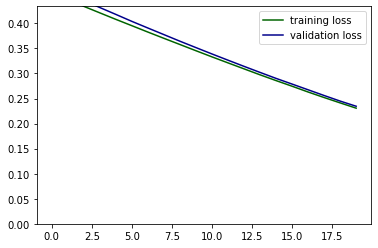

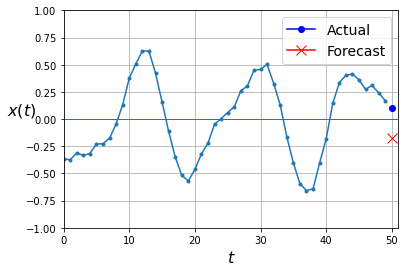

In [11]:
train_plot(model)

This is worse than a linear regression! At first, this may be surprising. But keep in mind, that we are training a model with only 3 parameters (versus 51 for the linear regression). Maybe we just need to go deeper?

## 1.4 A deeper RNN

Let's indeed go deeper. If we have multiple layers of recurrent nodes, we need to consider what to pass on between layers. In particular, we need to set `return_sequences=True` in a recurrent layer, so that all outputs are passed to the next layer. Otherwise, only the last otuput (corresponding to the last time step) is passed to the next layer.

In [12]:
model = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    SimpleRNN(20),
    Dense(1)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
63/63 [==============================] - 2s 13ms/step - loss: 0.0662 - val_loss: 0.0163
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0107 - val_loss: 0.0091
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 11/

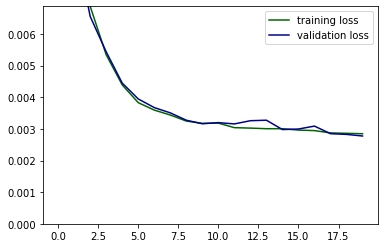

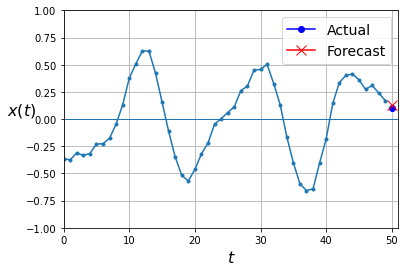

In [13]:
train_plot(model)

Already much better, right?

## 1.5 Using LSTMs

One problem with RNNs is that they often lack the ability to "remember" things over the long term. It's not so much of a problem with the simple sequences we are using here, but if you are doing more complex things like translating text, you will quickly realize the issue. One way to deal with this is to use "long short-term memory" cells. We can implement layers of those cells quite easily, exactly as with the `SimpleRNN` layers. Also, the same holds as before regarding whether we return a sequence or a value:

In [14]:
model = Sequential([
    LSTM(20, return_sequences=True, input_shape=[None, 1]),
    LSTM(20),
    Dense(1)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1760      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
63/63 [==============================] - 4s 27ms/step - loss: 0.0826 - val_loss: 0.0375
Epoch 2/20
63/63 [==============================] - 1s 20ms/step - loss: 0.0411 - val_loss: 0.0316
Epoch 3/20
63/63 [==============================] - 1s 20ms/step - loss: 0.0332 - val_loss: 0.0285
Epoch 4/20
63/63 [==============================] - 1s 19ms/step - loss: 0.0232 - val_loss: 0.0153
Epoch 5/20
63/63 [==============================] - 1s 19ms/step - loss: 0.0154 - val_loss: 0.0150
Epoch 6/20
63/63 [==============================] - 1s 19ms/step - loss: 0.0126 - val_loss: 0.0103
Epoch 7/20
63/63 [==============================] - 1s 19ms/step - loss: 0.0100 - val_loss: 0.0093
Epoch 8/20
63/63 [==============================] - 1s 20ms/step - loss: 0.0085 - val_loss: 0.0073
Epoch 9/20
63/63 [==============================] - 1s 19ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 10/20
63/63 [==============================] - 1s 19ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 11/

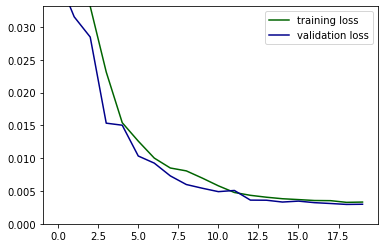

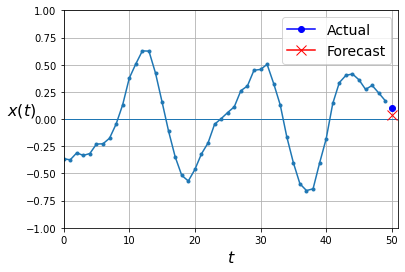

In [15]:
train_plot(model)

## 1.6 Using GRUs

The gated recurrent unit (GRU) is a simplification of the LSTM and tends to work better in practice. The implementation is the same as before:

In [16]:
model = Sequential([
    GRU(20, return_sequences=True, input_shape=[None, 1]),
    GRU(20),
    Dense(1)
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 20)          1380      
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 3,921
Trainable params: 3,921
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
63/63 [==============================] - 4s 30ms/step - loss: 0.0510 - val_loss: 0.0235
Epoch 2/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0198 - val_loss: 0.0158
Epoch 3/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0134 - val_loss: 0.0096
Epoch 4/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0082 - val_loss: 0.0059
Epoch 5/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 6/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 7/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 8/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 9/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 10/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 11/

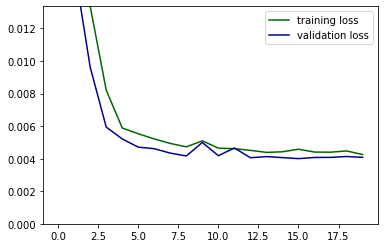

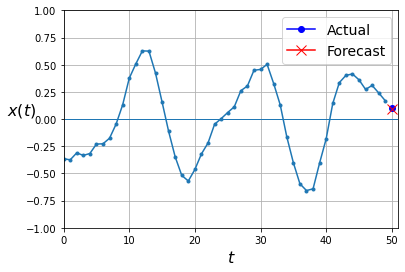

In [17]:
train_plot(model)

## 1.7 Using 1-dimensional convolutional layers

One-dimensional convolutional layers work exactly like two-dimensional convolutional layers. Except that they are one-dimensional, of course. They help to transmit a sequence into a smaller sequence. You can visualize the what happens in the layer below as follows:

```
1D conv layer with kernel size 4, stride 2, VALID padding:


Input:
   0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|

Output:
       0-3   2-5   4-7   6-9   8-11 10-13 ...-43 42-45 44-47 46-49
```

We add the `Conv1D` layer to our network, as usual. If you want to see the effect of the layer on the sequence, try changing the `input_shape` from `[None,1]` to `[50,1]`.

In [18]:
model = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",input_shape=[None, 1]),
    GRU(20),
    Dense(1)
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          100       
                                                                 
 gru_2 (GRU)                 (None, 20)                2520      
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,641
Trainable params: 2,641
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 0.0771 - val_loss: 0.0274
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0238 - val_loss: 0.0197
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0174 - val_loss: 0.0148
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0132 - val_loss: 0.0105
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0092 - val_loss: 0.0068
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 8/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 9/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 10/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 11/20
63/63 

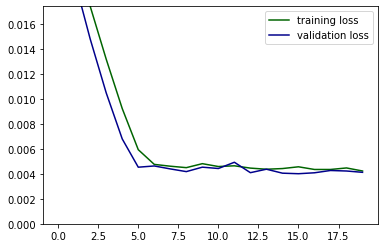

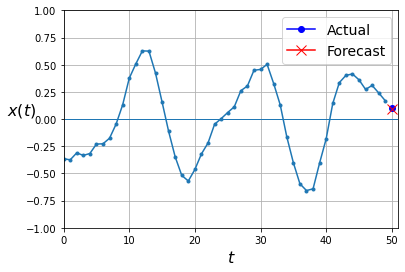

In [19]:
train_plot(model)

## 1.8 Forecasting multiple steps ahead

So far, we have only forecast 1 timestep ahead. We will now forecast 10 timesteps ahead, instead. For this, we have to recreate our datasets accordingly:

In [20]:
np.random.seed(351)

seq_steps = 50
series = generate_time_series(3000, seq_steps + 10)
X_train, y_train = series[:2000, :seq_steps], series[:2000, -10:, 0]
X_valid, y_valid = series[2000:2500, :seq_steps], series[2000:2500, -10:, 0]
X_test, y_test = series[2500:, :seq_steps], series[2500:, -10:, 0]

print(X_train.shape)
print(y_train.shape)

(2000, 50, 1)
(2000, 10)


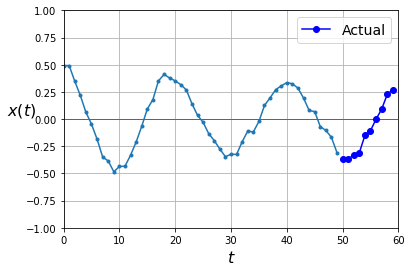

In [21]:
plot_series(X_valid, y_valid, series_to_plot = 0)

### Baseline

Our baseline will again be a linear regression model. This time, we need 10 outputs, to make the ten predictions.

In [22]:
model = Sequential([
    Flatten(input_shape=[50, 1]),
    Dense(10)
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                510       
                                                                 
Total params: 510
Trainable params: 510
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
63/63 [==============================] - 0s 2ms/step - loss: 0.2844 - val_loss: 0.1877
Epoch 2/20
63/63 [==============================] - 0s 920us/step - loss: 0.1495 - val_loss: 0.1202
Epoch 3/20
63/63 [==============================] - 0s 887us/step - loss: 0.1041 - val_loss: 0.0899
Epoch 4/20
63/63 [==============================] - 0s 871us/step - loss: 0.0812 - val_loss: 0.0733
Epoch 5/20
63/63 [==============================] - 0s 887us/step - loss: 0.0676 - val_loss: 0.0624
Epoch 6/20
63/63 [==============================] - 0s 855us/step - loss: 0.0587 - val_loss: 0.0548
Epoch 7/20
63/63 [==============================] - 0s 903us/step - loss: 0.0525 - val_loss: 0.0495
Epoch 8/20
63/63 [==============================] - 0s 887us/step - loss: 0.0480 - val_loss: 0.0457
Epoch 9/20
63/63 [==============================] - 0s 887us/step - loss: 0.0447 - val_loss: 0.0424
Epoch 10/20
63/63 [==============================] - 0s 903us/step - loss: 0.0420 - val_loss: 0.0400
E

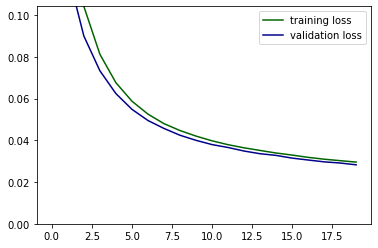

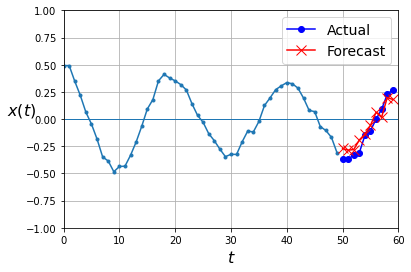

In [23]:
train_plot(model)

### Deep RNN: sequence-to-vector

We start with a deep RNN right from the get go. However, for now, we are only going to predict ten timesteps ahead with a sequence-to-vector model (i.e., we take the sequence `0,...,49` and predict `50,...,59` as a single output).

In [24]:
model = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    SimpleRNN(20),
    Dense(10)
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_6 (Dense)             (None, 10)                210       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
63/63 [==============================] - 2s 15ms/step - loss: 0.1342 - val_loss: 0.0803
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0586 - val_loss: 0.0419
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0393 - val_loss: 0.0336
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0339 - val_loss: 0.0304
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0304 - val_loss: 0.0291
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0280 - val_loss: 0.0263
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0252 - val_loss: 0.0269
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0243 - val_loss: 0.0217
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0219 - val_loss: 0.0214
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0200 - val_loss: 0.0207
Epoch 11/

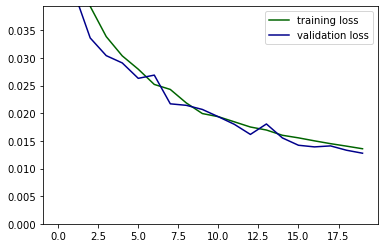

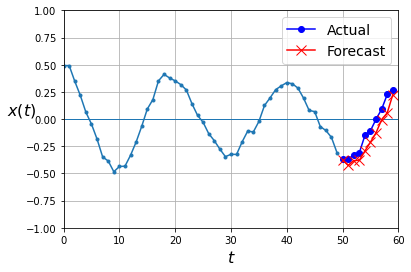

In [25]:
train_plot(model)

### Deep RNN: sequence-to-sequence

Now let's create an RNN that predicts the next 10 steps at each time step. That is, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Note that the model is causal: when it makes predictions at any time step, it can only see past time steps.

First, we need to re-define our y's:

In [26]:
y = np.empty((3000, seq_steps, 10))
for step_ahead in range(1, 10 + 1):
    y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + seq_steps, 0]
y_train = y[:2000]
y_valid = y[2000:2500]
y_test = y[2500:]

print(X_train.shape)
print(y_train.shape)

(2000, 50, 1)
(2000, 50, 10)


We can now define a model. Notice the only difference to the previous one is that the second `SimpleRNN` layer now also has `return_sequences=True`. The `Dense` layer is able to automatically handle sequences, as you will see with the output shape in the summary.

In [27]:
model = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    SimpleRNN(20, return_sequences=True),
    Dense(10)
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 dense_7 (Dense)             (None, None, 10)          210       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


For a fair comparison, we want to check the mean-square-error on the final time step only:

In [28]:
def last_time_step_mse(y_true, y_pred):
    return mean_squared_error(y_true[:, -1], y_pred[:, -1])

model.compile(loss="mse",
              optimizer=Adam(learning_rate=0.005),
              metrics=[last_time_step_mse])

log = model.fit(X_train, y_train, epochs=20,
                validation_data=(X_valid, y_valid))

Epoch 1/20
63/63 [==============================] - 2s 13ms/step - loss: 0.0762 - last_time_step_mse: 0.0690 - val_loss: 0.0513 - val_last_time_step_mse: 0.0411
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0455 - last_time_step_mse: 0.0352 - val_loss: 0.0457 - val_last_time_step_mse: 0.0319
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0427 - last_time_step_mse: 0.0310 - val_loss: 0.0424 - val_last_time_step_mse: 0.0289
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0402 - last_time_step_mse: 0.0272 - val_loss: 0.0405 - val_last_time_step_mse: 0.0250
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0387 - last_time_step_mse: 0.0253 - val_loss: 0.0383 - val_last_time_step_mse: 0.0230
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 0.0367 - last_time_step_mse: 0.0230 - val_loss: 0.0357 - val_last_time_step_mse: 0.0199
Epoch 7/20
63/63 [================

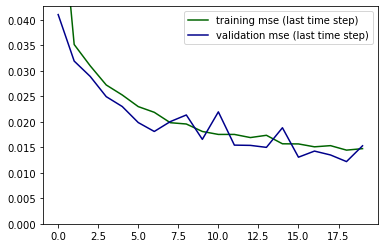

In [29]:
plt.plot(log.history['last_time_step_mse'],label = "training mse (last time step)",color='darkgreen')
plt.plot(log.history['val_last_time_step_mse'], label = "validation mse (last time step)",color='darkblue')
plt.legend()
ax = plt.gca()
ax.set_ylim([0, log.history['loss'][2]])
plt.show()

In [30]:
y_pred = model.predict(X_valid)[:,-1][...,np.newaxis]
y_pred[0]

array([[-0.37029767],
       [-0.4639078 ],
       [-0.48059776],
       [-0.5050182 ],
       [-0.3830523 ],
       [-0.23770836],
       [-0.03510841],
       [ 0.16353367],
       [ 0.3716356 ],
       [ 0.4480672 ]], dtype=float32)

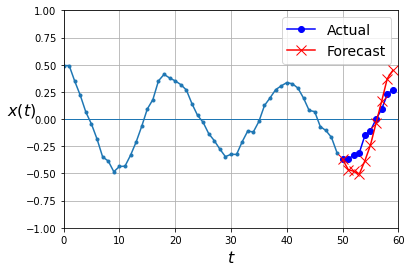

In [31]:
y_new = y_valid[:,-1]
plot_series(X_valid, y_new, y_pred, series_to_plot = 0)

# 2. TensorFlow Data API

We have used the TensorFlow Data API sometimes, without paying a lot of notice to it. For sequence predictions, however, a lot of complex data manipulation is necessary, so the functionality of the API can come in quite handy. Hence, we will take a brief look at some of the key features.

## 2.1 Generating and pre-processing data sets 

First of all, the Data API helps creating `Dataset`s made specifically for TensorFlow model training. It's quite straightforward to create a dataset from a list, matrix, array, or tensor:

In [32]:
dataset = Dataset.from_tensor_slices([1,2,3,4,5,6,7,8])

We can iterate through a dataset, for example with a for-loop. This is exactly what our training algorithm will do

In [42]:
for item in dataset:
    print(item)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


We can also inspect the type of data to be found in a `Dataset`:

In [34]:
dataset.element_spec

TensorSpec(shape=(), dtype=tf.int32, name=None)

The most important aspect about working with datasets is that we can directly apply some very important operations. One is to shuffle the data in the set. Especially when the dataset is large, we don't want to shuffle it too much, since this takes time. Hence, the `shuffle` operation is parametrized with a `buffer_size`. This controls over how many elements randomization happens. Run the following code a few times to see exactly how the randomization operates (note that 6, 7, or 8 will never appear in the first spot, 7, and 8 will never appear in the second spot, and so on)

In [35]:
dataset_new = dataset.shuffle(5)
for item in dataset_new:
    print(item)

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


The best part about using the Data API is that these operations happen at runtime. Hence, we only need to have enough memory for the original dataset, but not for all the possible randomized versions that might be called up when training a neural network (keep in mind that in each epoch the randomization is different, unless we specify `reshuffle_each_iteration=False`)

Another important feature of `Dataset`s is that we can batch together a number of data points. This is very important to perform mini-batch gradient descent. Generate a `dataset_new` using `datatset.batch(k)` where `k` is a number of your choice. Then print out the items of your new dataset to see what is happening.

In [37]:
dataset_new = dataset.batch(3)
for item in dataset_new:
    print(item)

tf.Tensor([1 2 3], shape=(3,), dtype=int32)
tf.Tensor([4 5 6], shape=(3,), dtype=int32)
tf.Tensor([7 8], shape=(2,), dtype=int32)


We can also `repeat` the data in our dataset (either a pre-specified number of times or infinitely often if we don't specify a number). The `take` operation specifies how many of the elements of the datasets to take out (in FIFO order!)

In [38]:
dataset_new = dataset.repeat().take(18)
for item in dataset_new:
    print(item)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


Using `map`, we can apply a function to all the elements of the dataset. We could specify the function somewhere else and call it here, but the quickest way to implement this is using so-called "lambda functions". Here, for example, we take every element from the dataset (and we call such an element `x`), then we multiply it by `2`.

In [40]:
dataset_new = dataset.map(lambda x: x*2)
for item in dataset_new:
    print(item)

tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)


Similarly, we can filter the data. Again, lambda functions can be useful here. Can you come up with a lambda-function that filters out only elements larger than `3`? Loop through your new dataset, to see what you got.

In [44]:
dataset_new = dataset.filter(lambda x: x > 3)
for item in dataset_new:
    print(item)

tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


### A slightly more complex example

We will now load some images from the `mnist` dataset. Don't worry too much about the content, the key here is how we will process them as a `Dataset`.

In [45]:
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

path = tf.keras.utils.get_file('mnist.npz', DATA_URL)
with np.load(path) as data:
    train_examples = data['x_train']
    train_labels = data['y_train']
    test_examples = data['x_test']
    test_labels = data['y_test']

11501568/11490434 [==============================] - 1s 0us/step


We used TensorFlow to download the images into a folder (you can see which one by typing in `path`). We also loaded each of `x_train`, `y_train`, `x_test`, and `y_test` as a numpy array. We will now directly convert the numpy arrays into datasets (one for training, one for testing). The code below shows you how to combine `x` and `y` into a single dataset, using tuples:

In [46]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

As before, we can easily check what our dataset contains. We see that the `x`-data are arrays of shape (28,28) and the `y`-data are individual points (i.e., a number indicating the class that the image belongs to)

In [47]:
train_dataset.element_spec

(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None))

We will now shuffle and batch our training dataset. Can you apply the `shuffle` operation (with a shuffle buffer size of 100) to the `train_dataset`, followed by the `batch` operation (with a batch size of 128)?

For the testing dataset, we don't need to shuffle it, so simply apply the `batch` operation:

With the line below, you can see how data is now returned: in batches of size 128 each!

In [ ]:
for item in train_dataset:
    print("x-shape: " + str(item[0].shape) + " | y-shape:" + str(item[1].shape))

Finally, we usually want to call `prefetch(1)` when we build a `Dataset` in this manner. The reason is, that our `Dataset` will work in parallel with the training process and things will speed up a lot. The following illustration from Geron, 2019, shows exactly why `prefetch` is useful:

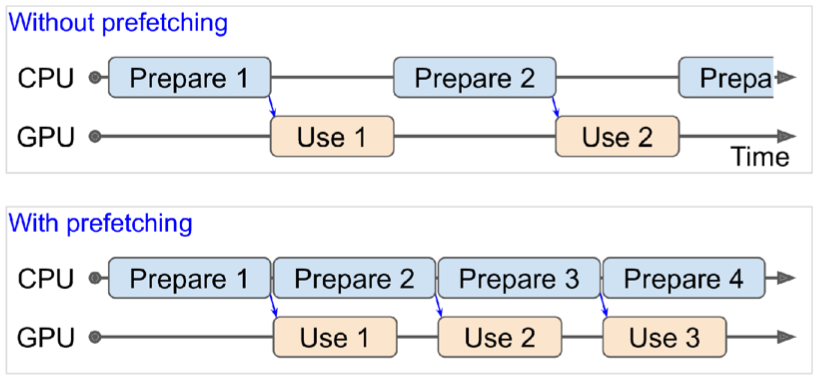

In [ ]:
train_dataset = train_dataset.prefetch(1)
test_dataset = test_dataset.prefetch(1)

We can now train our models using `train_dataset` instead of `x` and `y`, and evaluate them using `test_dataset`

## 2.2 Dealing with data that doesn't fit into memory

Sometimes, even the original dataset doesn't fit into memory, before any of the pre-procesisng. In this case, we want to load data on the fly.

We already saw the `ImageDataGenerator`, which can take images directly from files and generate a `flow` of images at runtime. More generally, TensorFlow provides the TFRecord format to save data and load it on the fly through a `TFRecordDataset`. Let's create some data in the right format, and call it into a dataset:

In [ ]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [ ]:
dataset = tf.data.TFRecordDataset(["my_data.tfrecord"])
for item in dataset:
    print(item)

We can also call up data without decompressing it. In the code below, we create a compressed TFRecord folder, and load from this folder without a complete decompression. Data is decompressed on the fly, too.

In [ ]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [ ]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

# 3. Creating chorales like Johann Sebastian Bach

## 3.1 Loading the data

We will work with the Bach chorales dataset. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains a chord, made up of 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played).

Our objective is to train a model that can predict the next time step (consisting of four notes), given a sequence of time steps from a chorale. We will later take a look at generating Bach-like music, one note at a time.

First, load the training, validation, and test data from Dropbox:

In [ ]:
path_to_data = tf.keras.utils.get_file("jsb_chorales.tgz",
                                       "https://www.dropbox.com/s/9pwoax3cuylmzht/jsb_chorales.tgz?dl=1",
                                      extract=True)
jsb_chorales_dir = os.path.join(os.path.abspath(os.path.join(path_to_data, os.pardir)),'jsb_chorales')

In [ ]:
def load_chorales(path_add):
    filepath = os.path.join(jsb_chorales_dir, path_add)
    return_list = []
    for file in [f for f in os.listdir(filepath) if f.endswith('.csv')]:
        return_list.append(pd.read_csv(os.path.join(filepath, file)).values.tolist())
    return return_list

In [ ]:
train_chorales = load_chorales('train')
valid_chorales = load_chorales('valid')
test_chorales = load_chorales('test')

Let's take a look at one data point:

In [ ]:
train_chorales[0]

We now write a few functions to listen to these chorales (you don't need to understand the details here, this is only to have a bit of fun with the exercise).

In [ ]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    return display(Audio(samples, rate=sample_rate))

We can use our functions to listen to the chorales. Try it out:

In [ ]:
play_chords(train_chorales[0])

We need to define a few things relating to the notes in the chorales. This will make pre-processing a lot easier later. Notes range from 36 (C1 = C on octave 1) to 81 (A5 = A on octave 5), plus 0 for silence:

In [ ]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

## 3.2 Preprocessing the data

In order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords. If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together. It's much better to predict one note at a time.

Hence, we will need to preprocess every chorale, turning each chord into an arpeggio (i.e., a sequence of notes rather than notes played simultaneuously). So each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes.

So what will our input sequences be for our RNN? We will create sequences made from 32 chords (128 notes). Each x will be a sequence of 127 notes (so the notes 1-127 of the 128 notes). The corresponding y will be the same sequence, but shifted by one (so the notes 2-128 of the 128 notes). This is a "sequence-to-sequence" approach. You could, of course, also try a "sequence-to-vector" approach and only predict the last note of each sequence. However, this won't pick up very well on the combinations of nodes in chords, so I wouldn't recommend it.

In principle, we could create a "sliding window" of 32 chords and go chord-by-chord. For example, if we have 100 chords in a chorale, then we could turn that chorale into 100 - 32 + 1 = 69 sequences of 32 chords. However, there will be a lot of correlation between the sequences, so we will instead slide our window by 16 chords. Hence, our chorale of 100 chords would now be turned into 5 sequences (the last one being from chords 65 to 97).

We will use a TensorFlow `Dataset` to manage our data pre-processing. It's not strictly necessary, as the amount of data isn't massive, but it will hopefully help introduce the concepts better.

We will start with a simple example before putting everything into a function. First, we convert one of our chorales datasets into a Tensor:

In [ ]:
chorales = tf.ragged.constant(train_chorales, ragged_rank=1)

We will also shift the values of the notes so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5). This is useful if you want to predict the notes through regression rather than classification (I don't recommend this, for reasons that will become clearer below). But it also helps to keep things more organized.

In the code below, can you complete the second line by specifying a note should remain itself if it is zero, but if it is not zero, it should be replaced by `note - min_note + 1`. Use [`tf.where`](https://www.tensorflow.org/api_docs/python/tf/where)!

In [ ]:
dataset_all = Dataset.from_tensor_slices(chorales)
dataset_all = dataset_all.map(lambda note: #

Let's take a look what kind of data we have so far:

In [ ]:
for item in dataset_all.take(3):
    print(item.shape)

Each datapoint of our `Dataset` is an individual chorale:

In [ ]:
item

We will now turn to processing a single of those chorales. Start by creating a new `Dataset` from the chorale. Each entry of that dataset is now a chord:

In [ ]:
chorale = iter(dataset_all).next()
dataset_single = Dataset.from_tensor_slices(chorale)
for item in dataset_single.take(5):
    print(item)

To demonstrate how things work, we will look at 3 chords at a time, and slide our window chord-by-chord.
Convert your chorale into multiple sequences of 3 chords, one apart, using the `window(3,1,drop_remainder=True)` operation on `dataset_single`. Run the complete code and compare the output of the previous step with the output below. Can you see what is happening?

In [ ]:
dataset_single = #
dataset_single = dataset_single.flat_map(lambda window: window.batch(3))
for item in dataset_single.take(3):
    print(item)

We turn what we just did into a function, so we can apply it to the dataset of all chorales.

In [ ]:
def to_windows(chorale):
    dataset_single = Dataset.from_tensor_slices(chorale)
    dataset_single = dataset_single.window(3, 1, drop_remainder=True)
    dataset_single = dataset_single.flat_map(lambda window: window.batch(3))
    return dataset_single

In [ ]:
dataset_all = dataset_all.flat_map(to_windows)
for item in dataset_all.take(3):
    print(item)

Now that we have created sequences of chords to be used as inputs, we need to turn the chords into arpeggios (i.e., convert everything into long lists of notes). Here, the lists will be of length 12, because we took 3 chords at a time. However, we will later work with 32 chords, so lists of length 128.

Complete the lambda function, by applying `tf.reshape(window, [-1])` to all `window` elements in the dataset.

In [ ]:
dataset_all = dataset_all.map(lambda window: #
for item in dataset_all.take(3):
    print(item)

We will also generate our `x` and our `y` from the lists:  elements 1-11 go into `x`, elements 2-12 go into `y`. Keep in mind that at runtime, our algorithm only sees **future** notes whenever it is working on one specific instance.

Again, compare the output of the previous cell with the output of the next cell to verify what is happening:

In [ ]:
dataset_all = dataset_all.map(lambda window: (window[:-1], window[1:]))
for item in dataset_all.take(3):
    print(item)

We can now put everything together into a `create_dataset` function, which we apply to all the chorales, whether training, validation, or testing. There are a few additional points that come up here that we didn't discuss before, but they are commented accordingly.

In [ ]:
def create_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                    window_size=32, window_shift=16, cache=True):

    def to_windows(chorale):
        dataset_single = tf.data.Dataset.from_tensor_slices(chorale)
        dataset_single = dataset_single.window(window_size, window_shift, drop_remainder=True)
        dataset_single = dataset_single.flat_map(lambda window: window.batch(window_size))
        return dataset_single

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.map(lambda note: tf.where(note == 0, note, note - min_note + 1))
    dataset = dataset.flat_map(to_windows)
    dataset = dataset.map(lambda window: tf.reshape(window, [-1]))
    if cache:
        dataset = dataset.cache() # If the memory is sufficient, we can cache the data, which makes it faster to call up
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size) # For training, we usually want to shuffle the data randomly
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda batch: (batch[:,:-1], batch[:,1:])) # Note: we are reshaping entire batches, not just single observations
    return dataset.prefetch(1)

In [ ]:
train_dataset = create_dataset(train_chorales, shuffle_buffer_size = 1000)
valid_dataset = create_dataset(valid_chorales)
test_dataset = create_dataset(test_chorales)

Let's take a look at one element from the training set to see if we have the expeted shapes:

In [ ]:
temp = iter(train_dataset).next()
print(temp[0].shape)
print(temp[1].shape)

## 3.3 Training a model

We are now ready to create a model.

- We could feed the note values directly to the model, as floats, but this would probably not give good results. Indeed, the relationships between notes are not that simple: for example, if you replace a C3 with a C4, the melody will still sound fine, even though these notes are 12 semi-tones apart (i.e., one octave). Conversely, if you replace a C3 with a C\#3, it's very likely that the chord will sound horrible, despite these notes being just next to each other. So we will use an `Embedding` layer to convert each note to a small vector representation. We will use 5-dimensional embeddings, so the output of this first layer will have a shape of `[batch_size, window_size, 5]`. Keep in mind, the number of dimensions is a hyperparameter that you may want to tune
- We will then feed this data into a stack of 4 `Conv1D` layers with. The `dilation_rate` specifies how spread apart each neuron's inputs are. The doubling of rates at each layer means that we are building a hierarchy of sequences, where the first layer captures only short sequences, and the last one captures long ones that consist of combinations of those short ones. The `'causal'` padding ensures that convolutions are padded such that there is no "looking into the future".
- We intersperse the layers with `BatchNormalization` layers for faster convergence.
- At the end, we have one `LSTM` layer to try to capture long-term patterns.
- Finally, a `Dense` layer with `'softmax'` activation is used to produce the final note probabilities. It will predict one probability for each chorale in the batch, for each time step, and for each possible note (including silence). So the output shape will be `[batch_size, window_size, 47]`.

In [ ]:
n_embedding_dims = 5

model = Sequential([
    Embedding(input_dim=n_notes, output_dim=n_embedding_dims,input_shape=[None]),
    Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    BatchNormalization(),
    Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    BatchNormalization(),
    Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    BatchNormalization(),
    Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    BatchNormalization(),
    LSTM(256, return_sequences=True),
    Dense(n_notes, activation="softmax")
])
model.summary()

The function below trains the model and plots the progress. Be aware that training may take a little bit of time.

In [ ]:
def train_and_plot(model, learning_rate = 0.001, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    model.compile(loss="sparse_categorical_crossentropy",
                    optimizer=Adam(learning_rate = learning_rate),
                    metrics = ['accuracy'])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 10, restore_best_weights=True)
    log = model.fit(train_dataset, epochs=epochs,
                        validation_data=valid_dataset,
                    callbacks = [early_stopping_cb])
    
    plt.plot(log.history['accuracy'],label = "training accuracy",color='green')
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_accuracy'], label = "validation accuracy",color='grey')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    plt.show()
    
    return model

In [ ]:
train_and_plot(model)

## 3.4 Creating our own chorale

Now that we can predict the next note of a chorale, let's create some music! We will take a few starting chords, predict the next note to play, then take all the notes so far (the starting ones and the predicted one), and predict the next note, and so on. To do this, we need to process our data a little bit.

Let's start somewhere. We will use 8 intial chords to start our own chorale. For simplicity, we take the first 8 chords from a test set chorale.
You will need to convert the notes back (from 36-81 to 1-46), unless a note is already a zero:

In [ ]:
seed_chords = test_chorales[0][:8]
arpeggio = #
arpeggio

Keep in mind that we made predictions on lists of notes (arpeggios) instead of chords. Hence, we convert our starting chords:

In [ ]:
arpeggio = tf.reshape(arpeggio, [1,-1])
arpeggio

Then, we predict the most likely note to come next. Use `model.predict` as well as `np.argmax` (with `axis=-1`):

In [ ]:
next_note = #
next_note

The code above predicts as many notes as we gave as an input (because of the sequence-to-sequence model structure). We only want the last chord:

In [ ]:
next_note = next_note[:1,-1:]
next_note

We can now add this note to our arpeggio, so we can keep predicting further notes. Use `tf.concat` with `axis=1`. You can concatenate the `arpeggio` with the `next_note` by putting them inside a list which is the primary input to `tf.concat`.

In [ ]:
arpeggio = #
arpeggio

Let's wrap all this into a function:

In [ ]:
def generate_chorale(model, seed_chords, output_chords):
    arpeggio = tf.constant([[note if note == 0 else note - min_note + 1 for note in chord] for chord in seed_chords], dtype=tf.int64)
    arpeggio = tf.reshape(arpeggio, [1,-1])
    for chord in range(output_chords):
        for note in range(4):
            next_note = np.argmax(model.predict(arpeggio), axis=-1)[:1,-1:]
            arpeggio = tf.concat([arpeggio, next_note], axis=1)
    arpeggio = tf.where(arpeggio == 0, arpeggio, arpeggio + min_note - 1)
    new_chorale = tf.reshape(arpeggio, shape=[-1, 4])
    return new_chorale

Try it out by creating your very own chorale:

In [ ]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

If you listened to your chorale, you may have noticed a major flaw of the approach: it is often too conservative. The model will not take any risk, it will always choose the note with the highest probability, and since repeating the previous note generally sounds good enough, it's the least risky option, so the algorithm will tend to make notes last longer and longer (and, if you are unlucky, simply play one chord after just a few time steps). Pretty boring. Plus, if you run the model multiple times, it will always generate the same melody.

So let's spice things up a bit! Instead of always picking the note with the highest score, we will pick the next note randomly, according to the predicted probabilities. For example, if the model predicts a C3 with 75% probability, and a G3 with a 25% probability, then we will pick one of these two notes randomly, with these probabilities. We will also add a temperature parameter that will control how "hot" (i.e., daring) we want the system to feel. A high temperature will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones.

In [ ]:
def generate_chorale_v2(model, seed_chords, output_chords, temperature=1):
    arpeggio = tf.constant([[note if note == 0 else note - min_note + 1 for note in chord] for chord in seed_chords], dtype=tf.int64)
    arpeggio = tf.reshape(arpeggio, [1,-1])
    for chord in range(output_chords):
        for note in range(4):
            next_note_probas = model.predict(arpeggio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpeggio = tf.concat([arpeggio, next_note], axis=1)
    arpeggio = tf.where(arpeggio == 0, arpeggio, arpeggio + min_note - 1)
    new_chorale = tf.reshape(arpeggio, shape=[-1, 4])
    return new_chorale

Try it out again. This should sound much better.

In [ ]:
new_chorale = generate_chorale_v2(model, seed_chords, 56)
play_chords(new_chorale)